<a href="https://colab.research.google.com/github/smritisrikanth/Machine-Learning/blob/main/HW3/Hw3_lab_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Lab
### 10 points total
### Version 1.0

Smriti Srikanth (ssrikan2), Hannah Qu (hqu6)

In [2]:
import torch
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [22]:
import torch
#from utils import *
import random
import time
import pdb
import json
import math
import matplotlib.pyplot as plt

n_letters=58
n_categories=18
n_hidden = 128
n_epochs = 200
print_every = 5000
plot_every = 1000
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Args:
            input_shape (int): size of the 1-hot embeddings for each character (this will be 58)
            hidden_layer_width (int): number of nodes in the single hidden layer within the model
            n_classes (int): number of output classes
        """
        super(RNN, self).__init__()
        ### TODO Implement the network architecture

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.f1 = torch.nn.Linear(input_size+hidden_size, hidden_size, bias = True)
        self.f2 = torch.nn.Linear(input_size+hidden_size, output_size, bias = True)
        self.g = torch.nn.Softmax()

    def forward(self, input, hidden):
        """Forward function accepts tensor of input data, returns tensor of output data.
        Modules defined in constructor are used, along with arbitrary operators on tensors
        """
        
        ### TODO Implement the forward function

        # input = self.f1(input)
        # hidden = self.f2(hidden)
        # hidden = self.f3(torch.cat([input,hidden],dim=1))
        # g = torch.nn.Softmax()
        # output = g(self.f4(hidden))

        hidden = self.f1(torch.cat([input,hidden],dim=1))
        output = self.g(self.f2(torch.cat([input,hidden],dim=1)))
        

        #your function will return the output y(t) and hidden h(t) from equation 1 in the docs
        return output, hidden 

    def initHidden(self):
        """
        This function initializes the first hidden state of the RNN as a zero tensor.
        """
        return torch.zeros(1, self.hidden_size)

def get_xy_pairs(names):
    #TODO 
    #process the names dict and convert into a list of (x,y) pairs. x is a 1-hot tensor of size (num_characters_in_name, 1, n_letters)
    #y is a scalar representing the category of the language, there are 18 languages, assign an index between 0-17 to each language and y represents this index.
    #you may make use of the nameToTensor() function in the utils.py file to help you with this function

    list_of_pairs = []
    categories = {}
    y = 0

    for language in names.keys():
      categories[language] = y
      for name in language:
        x = nameToTensor(name)
        list_of_pairs.append([x,y])
      y = y+1

    return list_of_pairs

def create_train_and_test_set(list_of_pairs):
    #TODO 
    #process the list of (x,y) pairs and split them 80-20 into train and test set
    #train_x is a list of name embeddings each of size (num_characters_in_name, 1, n_letters), train_y is the correponding list of language category index. Same for test_x and test_y

    random.seed(0)

    train_x = []
    train_y = []
    test_x = []
    test_y = []

    for pair in list_of_pairs:
      if random.randrange(0,10) > 1:
        train_x.append(pair[0])
        train_y.append(pair[1])
      else:
        test_x.append(pair[0])
        test_y.append(pair[1])

    return train_x, train_y, test_x, test_y

rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()


def train(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    loss = 0
    cel = []
    for x, y in zip(train_x, train_y):
        hidden = rnn.initHidden()
        for i in range(x.size()[0]):
            output, hidden = rnn(x[i], hidden)

        loss += criterion(torch.log(output), torch.tensor(y).unsqueeze(0)) #the unsqueeze converts the scalar y to a 1D tensor

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


def test(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    outputs = []
    labels = []

    loss = 0
    with torch.no_grad(): 
        for x, y in zip(train_x, train_y):
            hidden = rnn.initHidden()
            for i in range(x.size()[0]):
                output, hidden = rnn(x[i], hidden)
                outputs.append(output)
                labels.append(y)
            loss += criterion(torch.log(output), torch.tensor(y).unsqueeze(0)) #the unsqueeze converts the scalar y to a 1D tensor

    return [loss, outputs, labels]


# Keep track of losses for plotting
current_loss = 0
all_losses_train = []
all_losses_test = []

#names is your dataset in python dictionary form. Keys are languages and values are list of words belonging to that language
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
with open('/content/drive/My Drive/names.json', 'r') as fp:
    names = json.load(fp)

list_of_pairs = get_xy_pairs(names)
train_x, train_y, test_x, test_y = create_train_and_test_set(list_of_pairs)

for epoch in range(1, n_epochs + 1):
    train(train_x, train_y)
    current_loss = test(train_x, train_y)[0]
    all_losses_train.append(current_loss)
    current_loss = test(test_x, test_y)[0]
    all_losses_test.append(current_loss)
    outputs = test(test_x, test_y)[1]
    labels = test(test_x, test_y)[2]
    


#saving your model
torch.save(rnn, 'rnn.pt')

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Instructions: This notebook is intended to for answering the questions in the HW3_Programming pdf. You will answer in the space provided.

1) (2 points) Plot the Cross-entropy vs. epoch curve for both the training data and the testing data. Do you see over-fitting?

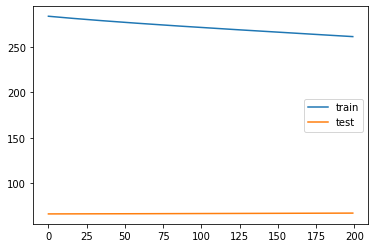

In [26]:
#TODO plot

plt.plot(all_losses_train, label = 'train')
plt.plot(all_losses_test, label = 'test')
plt.legend()

Overfitting is not seen here, since the error is much larger for the training data than for the testing data.

2) (4 points) Plot a confusion matrix for the test set for all the 18 languages.  What can you infer from it? What languages are confused the most?

1.0 Czech Vietnamese
1.0 Arabic Scottish
1.0 Japanese Vietnamese
1.0 Chinese Vietnamese
1.0 Vietnamese Vietnamese
1.0 Russian Vietnamese
1.0 French Portuguese
0.5 Irish Vietnamese
0.5 Irish Scottish
1.0 English Italian
1.0 Spanish Vietnamese
1.0 Greek Vietnamese
0.25 Portuguese Vietnamese
0.25 Portuguese English
0.25 Portuguese Portuguese
0.25 Portuguese Scottish
1.0 Scottish Vietnamese
0.5 Korean Vietnamese
0.5 Korean Portuguese
1.0 Polish Scottish


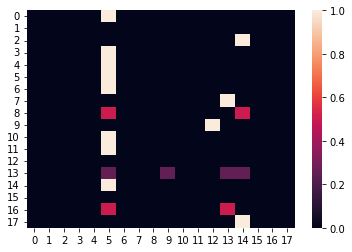

In [18]:
#TODO, your plot and some discussion on the plot
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize

y = 0
categories = {}
for language in names.keys():
      categories[y] = language
      y = y+1

matrix = np.zeros([18,18])

for i in range (len(outputs)):
    matrix[labels[i]][np.argmax(np.array(outputs[i]))] += 1

normalized_matrix = normalize(matrix,axis=1,norm='l1')

for i in range (18):
  for j in range(18):
    if normalized_matrix[i][j] > 0:
      print(normalized_matrix[i][j], categories[i], categories[j])

sns.heatmap(normalized_matrix)
plt.show()

The confusion matrix displays that while the model performs relatively well, there are a few languages that are much more difficult to identify than others. Vietnamese appears to be the most confusing language, closely followed by Scottish and Portugese.

(3) (4 points) So far you randomly split the dataset uniformly at random into an 80:20 partition. However, this could mean unbalanced training data since all languages might not have the same number of names in the training set. This could in turn adversely affect performance. Could you think of some way of mitigating this? Can you choose to split the dataset more intelligently? Implement your idea (you are free to use existing functions from scikit-learn or any other python library for this) and report differences in accuracy with your new method over the previous uniformly at random partition.

This could be mitigated by using bootstrapping (repeated sampling) to increase the size of the training set for each language, as well as ensure a training set of equal size for each language. The implementation of this below clearly results in the training loss decreasing more over time, as well as the actual values of the testing loss being much lower.

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


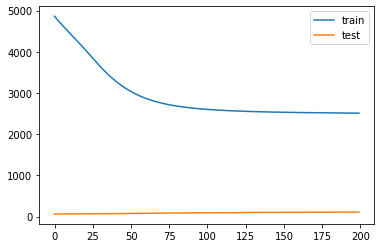

In [4]:
#TODO, your answer

import torch
#from utils import *
import random
import time
import pdb
import json
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

n_letters=58
n_categories=18
n_hidden = 128
n_epochs = 200
print_every = 5000
plot_every = 1000
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Args:
            input_shape (int): size of the 1-hot embeddings for each character (this will be 58)
            hidden_layer_width (int): number of nodes in the single hidden layer within the model
            n_classes (int): number of output classes
        """
        super(RNN, self).__init__()
        ### TODO Implement the network architecture

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.f1 = torch.nn.Linear(input_size+hidden_size, hidden_size, bias = True)
        self.f2 = torch.nn.Linear(input_size+hidden_size, output_size, bias = True)
        self.g = torch.nn.Softmax()

    def forward(self, input, hidden):
        """Forward function accepts tensor of input data, returns tensor of output data.
        Modules defined in constructor are used, along with arbitrary operators on tensors
        """
        
        ### TODO Implement the forward function

        # input = self.f1(input)
        # hidden = self.f2(hidden)
        # hidden = self.f3(torch.cat([input,hidden],dim=1))
        # g = torch.nn.Softmax()
        # output = g(self.f4(hidden))

        hidden = self.f1(torch.cat([input,hidden],dim=1))
        output = self.g(self.f2(torch.cat([input,hidden],dim=1)))
        

        #your function will return the output y(t) and hidden h(t) from equation 1 in the docs
        return output, hidden 

    def initHidden(self):
        """
        This function initializes the first hidden state of the RNN as a zero tensor.
        """
        return torch.zeros(1, self.hidden_size)

def get_xy_pairs(names):
    #TODO 
    #process the names dict and convert into a list of (x,y) pairs. x is a 1-hot tensor of size (num_characters_in_name, 1, n_letters)
    #y is a scalar representing the category of the language, there are 18 languages, assign an index between 0-17 to each language and y represents this index.
    #you may make use of the nameToTensor() function in the utils.py file to help you with this function

    list_of_pairs = []
    categories = {}
    y = 0

    for language in names.keys():
      categories[language] = y
      for name in language:
        x = nameToTensor(name)
        list_of_pairs.append([x,y])
      y = y+1

    return list_of_pairs

def create_train_and_test_set(list_of_pairs):
    #TODO 
    #process the list of (x,y) pairs and split them 80-20 into train and test set
    #train_x is a list of name embeddings each of size (num_characters_in_name, 1, n_letters), train_y is the correponding list of language category index. Same for test_x and test_y

    random.seed(0)

    full_train_x = []
    full_train_y = []
    full_test_x = []
    full_test_y = []

    i = 0
    curr = []
    curr_train = []
    curr_test = []
    for pair in list_of_pairs:
      if pair[1] == i:
        curr.append(pair)
      else:
        i += 1
        for p in curr:
          if random.randrange(0,10) > 1:
            curr_train.append(p)
          else:
            curr_test.append(p)
        curr_train = resample(curr_train, n_samples = 100)
        for p in curr_train:
          full_train_x.append(p[0])
          full_train_y.append(p[1])
        for p in curr_test:
          full_test_x.append(p[0])
          full_test_y.append(p[1])
        curr_train = []
        curr_test = []
        curr = []
        curr.append(pair)
      # if pair[1] == i:
      #   curr_x.append(pair[0])
      #   curr_y.append(pair[1])
      # else:

      #   train_x, test_x, train_y, test_y = train_test_split(curr_x,curr_y,test_size = 0.2)
      #   curr_x = []
      #   curr_y = []
      #   curr_x.append(pair[0])
      #   curr_y.append(pair[1])
      #   i += 1
      #   full_train_x += train_x
      #   full_train_y.append(train_y)
      #   full_test_x.append(test_x)
      #   full_test_y.append(test_y)

    return full_train_x, full_train_y, full_test_x, full_test_y

rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

def train(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    loss = 0
    cel = []
    for x, y in zip(train_x, train_y):
        hidden = rnn.initHidden()
        for i in range(x.size()[0]):
            output, hidden = rnn(x[i], hidden)

        loss += criterion(torch.log(output), torch.tensor(y).unsqueeze(0)) #the unsqueeze converts the scalar y to a 1D tensor

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


def test(train_x, train_y):
    """train_x and train_y are lists with names and correspoonding labels"""
    outputs = []
    labels = []

    loss = 0
    with torch.no_grad(): 
        for x, y in zip(train_x, train_y):
            hidden = rnn.initHidden()
            for i in range(x.size()[0]):
                output, hidden = rnn(x[i], hidden)
                outputs.append(output)
                labels.append(y)
            loss += criterion(torch.log(output), torch.tensor(y).unsqueeze(0)) #the unsqueeze converts the scalar y to a 1D tensor

    return [loss, outputs, labels]


# Keep track of losses for plotting
current_loss = 0
all_losses_train = []
all_losses_test = []
y_pred = []

#names is your dataset in python dictionary form. Keys are languages and values are list of words belonging to that language
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
with open('/content/drive/My Drive/names.json', 'r') as fp:
    names = json.load(fp)

list_of_pairs = get_xy_pairs(names)
train_x, train_y, test_x, test_y = create_train_and_test_set(list_of_pairs)

for epoch in range(1, n_epochs + 1):
    train(train_x, train_y)
    current_loss = test(train_x, train_y)[0]
    all_losses_train.append(current_loss)
    current_loss = test(test_x, test_y)[0]
    all_losses_test.append(current_loss)
    outputs = test(test_x, test_y)[1]
    labels = test(test_x, test_y)[2]
    


#saving your model
torch.save(rnn, 'rnn.pt')

plt.plot(all_losses_train, label = 'train')
plt.plot(all_losses_test, label = 'test')
plt.legend()